In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 11.2: The principle of maximum entropy for discrete random variables

## Objectives
+ Learn how to find the maximum entropy distribution for discrete random variables.

## The Brandeis Dice Problem
This is from the 1962 Brandeis lectures of E. T. Jaynes.

> When a die is tossed, the number of spots up can have any value $x$ in $1,\dots,6$. Suppose a die has been tossed $N$ times and we are told only that the average number of spots up was not $3.5$ (as we might expect from an "honest" die) but 4.5. Given this information, <u>and nothing else</u>, what probability should we assign to $x$ spots on the next toss?

Let $X$ be a random variable corresponding to the result of tossing the die.
The description above imposes the following mean value constraint on the random variable $X$:
$$
\sum_{x=1}^6 x p(x) = 4.5.
$$
As we discussed in the lecture, to come up with a probability mass function for $X$ you have to maximize the entropy subject to the constraints above.
We saw that this constrained optimization problem has a unique solution of the form:
$$
p(x) = \frac{\exp\{\lambda x\}}{Z(\lambda)},
$$
where $Z(\lambda)$ is the *partition function*:
$$
Z(\lambda) = \sum_{i}e^{\lambda i} = e^{\lambda} + e^{2\lambda} + \dots + e^{6\lambda},
$$
and $\lambda$ is a parameter to be tuned so that the constraint is satisfied.
We will identify $\lambda$ by solving a root finding problem.
To this end, let us write the partition function as:
$$
Z(\lambda) = \left(e^{\lambda}\right)^1+\left(e^{\lambda}\right)^2 + \dots + \left(e^{\lambda}\right)^6.
$$
According to the theory, in order to find $\lambda$ we must solve:
$$
\frac{\partial \log Z}{\partial \lambda} = 4.5.
$$
We are going to use sympy to find the derivative.

In [2]:
import sympy as sm
s_lam = sm.Symbol('lambda')
s_Z = 0
for n in range(1, 7):
    s_Z += sm.exp(n * s_lam)
s_Z

exp(6*lambda) + exp(5*lambda) + exp(4*lambda) + exp(3*lambda) + exp(2*lambda) + exp(lambda)

and here is the derivative of the logarithm:

In [3]:
s_dZdlam = sm.diff(sm.log(s_Z), s_lam)
s_dZdlam

(6*exp(6*lambda) + 5*exp(5*lambda) + 4*exp(4*lambda) + 3*exp(3*lambda) + 2*exp(2*lambda) + exp(lambda))/(exp(6*lambda) + exp(5*lambda) + exp(4*lambda) + exp(3*lambda) + exp(2*lambda) + exp(lambda))

Notice that this is nothing more but the expectation of $x$.
That's super easy to program:
Let's solve this root-finding problem numerically using the [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method).

In [4]:
import scipy.optimize

# The function of which the root we want to find
def f(lam):
    p_unormalized = np.exp(np.arange(1, 7) * lam)
    p = p_unormalized / np.sum(p_unormalized)
    E_X = np.sum(np.arange(1, 7) * p)
    return E_X - 4.5

# Left bound for x
a = -2
# Right bound for x
b = 2
res = scipy.optimize.root_scalar(f, bracket=(a,b), method='brentq',
                                 xtol=1e-20,
                                 rtol=1e-15)
print(res)
lam = res.root
print('Lambda = {0:1.2f}'.format(lam))
# The maximum entropy probabilities
p = np.exp(lam * np.arange(1, 7))
p = p / np.sum(p)
print('p = ', p)

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 0.3710489380810334
Lambda = 0.37
p =  [0.05435317 0.07877155 0.11415998 0.1654468  0.23977444 0.34749407]


Check that the expectation turns out to be correct:

In [5]:
(p * np.arange(1, 7)).sum()

4.5

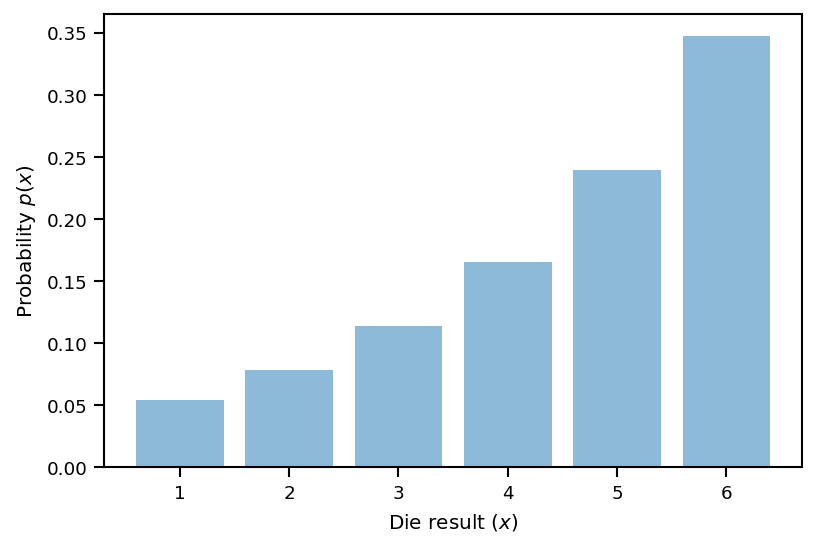

In [6]:
fig, ax = plt.subplots(dpi=150)
plt.bar(np.arange(1, 7), p, alpha=0.5)
ax.set_xlabel('Die result ($x$)')
ax.set_ylabel('Probability $p(x)$');

## Questions

+ Rerun the code above assuming that the mean is 3.5. What kind of distribution do you find? Why?
+ If you have some time to spare, modify the example above to add the constraint that the variance of $X$ should be 0.2. Hint: First, translate the constraint about the variance to a constraint about $\mathbb{E}[X^2]$. Second, you need to introduce one more parameter to optimize for. Call it $\mu$. The distribution would be $p(x) = \frac{\exp\{\lambda x + \mu x^2\}}{Z(\lambda,\mu)}$. Then derive the set of non-linear equations you need solve to find $\lambda$ and $\mu$ by expanding these two equations:
$$
\frac{\partial Z}{\partial \lambda} = \mathbb{E}[X],
$$
and
$$
\frac{\partial Z}{\partial \mu} = \mathbb{E}[X^2].
$$
Finally, use [scipy.optimize.root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root) to solve the root-finding problem.
Be careful with this because it could take several hours to do right...